In [109]:
import torch as torch

In [110]:
if torch.cuda.is_available():
    cuda_id = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(cuda_id)
    device = "cuda:0"
else:
    device = "cpu"

### Download and preparethe data

We'll use the CIFAR10 dataset

In [111]:
import os
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [112]:
batch_size = 100

In [113]:
# download and augment the training dataset
if not os.path.exists("./data"):
    os.mkdir("./data")

data = CIFAR10(
    root="./data",
    train=True,
    transform=transforms.Compose(
        [
            transforms.RandomHorizontalFlip(),
            transforms.RandomResizedCrop(size=32, ratio=(0.9, 1.1)),
            transforms.ToTensor(),
            transforms.Normalize(0, 1),
        ]
    ),
    download=True,
)

data_loader = DataLoader(data, batch_size=batch_size, shuffle=True)

test_data = CIFAR10(
    root="./data",
    train=False,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(0, 1),
        ]
    ),
    download=True,
)
test_loader = DataLoader(data, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [114]:
classes = data.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

### Print out an example image

In [115]:
import matplotlib.pyplot as plt

In [116]:
def display(image, size=8):
    print(image[0].shape)
    image = image[0].permute((1, 2, 0))
    plt.figure(figsize=(size, size))
    plt.axis("off")
    plt.imshow(image)
    plt.show()

torch.Size([3, 32, 32])


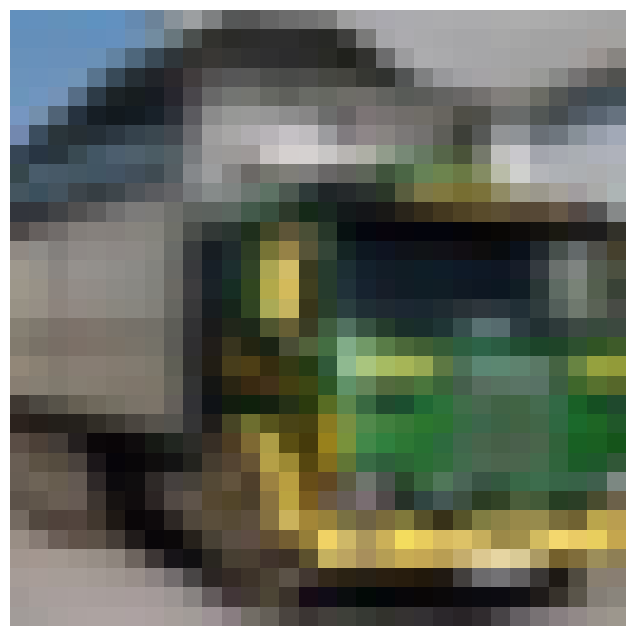

In [117]:
display(data[14])

### Split a batch of data into batch of patches

In [118]:
import torchvision.utils as vutils

In [119]:
def batch_patch(tensor, step=4):
    if len(tensor.shape) == 3:
        return (
            tensor.unfold(0, 3, 3)
            .unfold(1, step, step)
            .unfold(2, step, step)
            .flatten(start_dim=0, end_dim=2)
        )
    return (
        tensor.unfold(1, 3, 3)
        .unfold(2, step, step)
        .unfold(3, step, step)
        .squeeze()
        .flatten(start_dim=1, end_dim=2)
    )

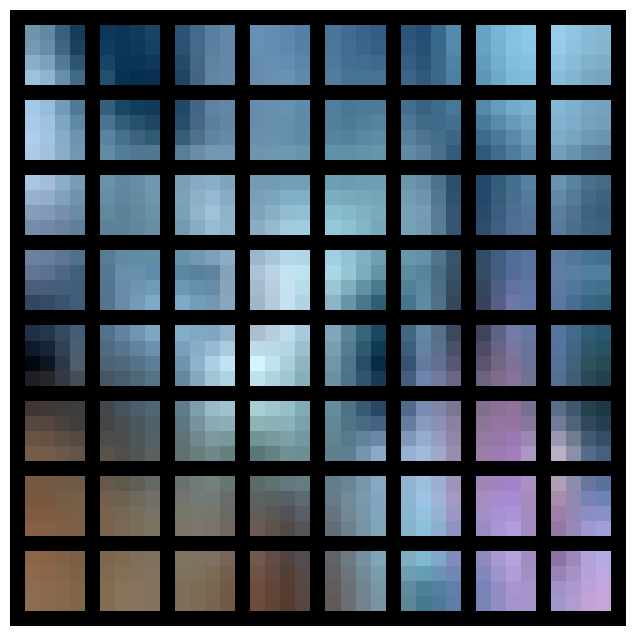

In [120]:
d = next(iter(data_loader))[0]

step = 4
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(
    (
        vutils.make_grid(
            batch_patch(d, step)[0], nrow=32 // step, padding=1, normalize=True
        )
        .permute(1, 2, 0)
        .detach()
        .cpu()
        .numpy()
    )
)

### Implement the model

In [121]:
import torch.nn as nn

First implement the learnable positional encoding layer - it was used in DDPM lab

In [122]:
class PositionalEncoding(nn.Module):
    def __init__(self, input_size=65, d=25, n=10000, output_size=256):
        super(PositionalEncoding, self).__init__()
        denominator = torch.pow(n, torch.arange(d) / d)
        numerator = torch.arange(input_size).reshape(-1, 1)
        self.inputs = torch.concat(
            [torch.sin(numerator / denominator), torch.cos(numerator / denominator)], 1
        ).to(device)
        self.network = nn.Sequential(
            nn.Linear(2 * d, out_features=output_size),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=output_size, out_features=output_size),
        )

    def forward(self, k):
        return self.network(self.inputs[k])

Implement a transformer block - We'll need a few of them so it's easier to make a separate class

In [123]:
class TransformerBlock(nn.Module):
    def __init__(self, n_dims=256, n_heads=8):
        super(TransformerBlock, self).__init__()
        self.norm = nn.LayerNorm(n_dims)
        self.attention = nn.MultiheadAttention(n_dims, n_heads)
        self.network = nn.Sequential(
            nn.LayerNorm(n_dims),
            nn.Linear(n_dims, 2 * n_dims),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(2 * n_dims, n_dims),
            nn.Dropout(0.2),
        )

    def forward(self, input):
        residual = input
        out = self.norm(input)
        out = self.attention(out, out, out)[0] 
        out += residual
        residual2 = out
        out = self.network(out)
        out += residual2
        return out

Whole model

In [124]:
class VisionTransformerModel(nn.Module):
    def __init__(self, n_classes, patch_size=4, im_size=32, n_dims=256):
        super(VisionTransformerModel, self).__init__()
        self.patch_size = patch_size
        self.token = torch.zeros(256, dtype=torch.float32,requires_grad=True,device=device)
        self.positional_embedding_keys = torch.arange((im_size // patch_size) ** 2 + 1)
        self.patch_flatten = nn.Flatten(start_dim=-3)
        self.embed = nn.Linear(3 * patch_size**2, n_dims)
        self.positional_encode = PositionalEncoding(input_size=n_dims, output_size=256)
        self.dropout1 = nn.Dropout(0.2)
        self.transformers = nn.Sequential(
            TransformerBlock(n_dims=n_dims),
            TransformerBlock(n_dims=n_dims),
            TransformerBlock(n_dims=n_dims),
            TransformerBlock(n_dims=n_dims),
            TransformerBlock(n_dims=n_dims),
            TransformerBlock(n_dims=n_dims),
        ).to(device)
        self.normalization = nn.LayerNorm(n_dims)
        self.MLP = nn.Sequential(
            nn.Linear(n_dims, 2 * n_dims),
            nn.ReLU(inplace=True),
            nn.Linear(2 * n_dims, n_classes),
            nn.Softmax(dim=1),
        )

    def forward(self, img):
        patched = batch_patch(img, self.patch_size)
        flattened = self.patch_flatten(patched)
        embedded = self.embed(flattened)

        class_token = torch.ones(img.shape[0]).to(device).reshape(-1, 1, 1) * self.token
        with_token = torch.concat([class_token, embedded], 1)

        encoding = self.positional_encode(self.positional_embedding_keys)
        with_encode = with_token + encoding

        tr = self.dropout1(with_encode)
        tr = self.transformers(tr)[:, 0]
        normalized = self.normalization(tr)
        return self.MLP(normalized)

### Prepare the model for training

In [125]:
model = VisionTransformerModel(len(data.classes)).to(device)

In [126]:
from graphviz import Digraph
from torchviz import make_dot
import torch
from torch.autograd import Variable
x = Variable(torch.rand((2,3,32,32)).to(device), requires_grad=True)
y = model(x)

make_dot(y).render("attached", format="png")

'attached.png'

In [127]:
params = [p for p in model.parameters()] + [model.token]
optimizer = torch.optim.AdamW(params, lr=0.001, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [100, 150], 0.1)
loss_fn = torch.nn.CrossEntropyLoss()

In [128]:
labels = nn.functional.one_hot(
    torch.tensor([i for i in range(len(data.classes))]), num_classes=len(classes)
).detach()
labels = torch.as_tensor(labels,dtype=torch.float32,device=device)

In [129]:
for epoch in range(160):
    iteration = 0
    total_loss = 0
    print("epoch:", epoch)
    for batch in data_loader:
        iteration = 0
        total_loss = 0
        batch_data = batch[0].to(device)
        batch_labels = labels[batch[1]]

        optimizer.zero_grad()
        pred = model(batch_data)
        loss = loss_fn(pred, batch_labels)
        loss.backward()
        optimizer.step()

        total_loss += loss
        iteration += 1

    scheduler.step()
    print(" - loss:", total_loss.item() / iteration)

epoch: 0
 - loss: 2.3026397228240967
epoch: 1
 - loss: 2.3027589321136475
epoch: 2
 - loss: 2.3026537895202637
epoch: 3


KeyboardInterrupt: 

In [ ]:
model.eval()

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(100 * correct / total, "%")

In [ ]:
d = next(iter(test_loader))[0][:16].to(device)

classification = torch.argmax(model(d), 1)

for c in classification:
    print(classes[c],end = " ")

step = 4
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(
    (
        vutils.make_grid(d, nrow=4, padding=1, normalize=True)
        .permute(1, 2, 0)
        .detach()
        .cpu()
        .numpy()
    )
)